#### The purpose of this notebook is to:
    1. Import images of grids of solar panels from ./Data/170725_Panel_Grids_EL2.zip
    2. Determine the grid's outer perimeter.
    3. Deskew and center the grid.
    4. Detect vertical and horizontal lagunas between the panels.
    5. Use the results to crop and save each panel.
    6. Save the results to a directory in ./Data, providing a unique identifier for each panel.

In [1]:
from zipfile import ZipFile
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

##### 1. Import panel grid.

In [171]:
# Hough transform
# Define a range of angles, radii
# For each angle, define a vector (cos(theta), sin(theta))

# Iterate over image. At each pixel;
#   > Form a vector (x, y)
#   > Take the dot product of this vector with all angles. (Result is point projection distance from center)
#   > Add to bins

# We can do the above simultaneously:
#  > Form a matrix C of coordinates (x, y) for all pixels.
#  > Let the Hough vector be u = (cos(theta), sin(theta)).
#  > Drop all zero pixels to form C'.
#  > Compute C'u = r, where r is a vector of project distances from the origin

# We can generalize the above further by letting U = [u1, u2, ..., un] where n is the number of angular bins.
# Then: C'U = R, such that R = [r1, r2, ..., rn] where ri is a vector of projection distances at angle i.

def my_hough_transform(binary_image, angle_bins, radii_bins):
    """
        angles in angle_bins are in radians
        radii in radii bins are in normalized coordinates [0, 1]
    """
    # Define basis vectors at defined angular spacing
    U = np.array([np.cos(angle_bins), np.sin(angle_bins)])
    # ^ Columns are u1, ..., where ui = (cos(theta_i), sin(theta_i))
    
    # Get cartesian position of non-zero image elements
    C       = np.array(np.nonzero(binary_image), dtype=np.float32) # i, j indices
    max_mag = 0.5*np.sqrt(binary_image.shape[0]**2 + binary_image.shape[1]**2) # Magnitude of largest vector
    C[0, :] = (binary_image.shape[0]/2 - C[0, :])/max_mag # Normalized y coordinates, [-1, 1]
    C[1, :] = (binary_image.shape[1]/2 - C[1, :])/max_mag # Normalized x coordinates
    C       = np.flip(C, axis = 0) # (y, x) -> (x, y)
    
    # Project the non-zero elements onto the basis vectors
    R = np.matmul(C.T, U) # R = [r1, ..., rn] where ri is a vector of projection distances at angle i
    
    # Bin the values in R's columns at the specfied radii
#     H = np.zeros(shape = [radii_bins.shape[0], angle_bins.shape[0]]) # Columns correspond to angles, rows to specfied radii
#     for j, radial_distances_vector in enumerate(R.T):
#         H[:, j] = np.histogram(radial_distances_vector, bins = radii_bins) # Need to drop topmost/bottommost?
    
    H = R
    
    # Return the Hough matrix
    return H, radii_bins, angle_bins

In [172]:
def display_image(img):
    """
    Plots a single image, without axes.
    
    Arguments
        img is a 2D np.float32 array
    """
    plt.figure(figsize = (15, 7))
    plt.imshow(img.T, cmap = 'gray');
    plt.axis('off');

In [176]:
def deskew_and_center(image):
    """
    Deskews and centers a grid of solar panel images.
    
    1. Inverts and thresholds image.
    2. Determines suitable parameters for a Hough transform. (distance from edge, range of angles)
    3. Applies the Hough transform in each direction (N, E, S, W).
    4. Identifies the angle + radial distance that yield a peak.
    5. Aligns the image frame's and grid rectangle's centers.
    6. Rotates the grid.
    
    Sub-functions:
    
    Arguments:
        img is a 2D np.float32 array of a grid of solar panels
    """
    
    # 1. Invert and threshold the image.
    THRESHOLD = 150
    image = 255. - image
    image = (image > THRESHOLD).astype(np.float32)
    
    # 2. Determine suitable parameters for a Hough transform.
    if image.shape[0] > image.shape[1]:
        image = image.T
    angle_bins = np.arange(0, np.pi, 0.1*np.pi) # 10 bins
    radii_bins  = np.arange(0.95, 1, 0.01) # 6 bins
    H, r, th  = my_hough_transform(image, angle_bins, radii_bins)
    
    display_image(image)
    
    return H, r, th

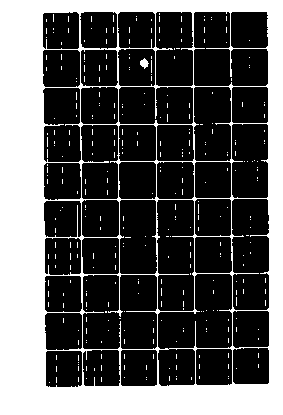

In [178]:
_ = True
with ZipFile('./Data/170725_Panel_Grids_EL2.zip', mode = 'r') as grid_archive:
    for filename in grid_archive.infolist():
        with grid_archive.open(filename) as file:
            img = Image.open(file).convert('L')
            img = np.array(img.getdata()).reshape(img.size[1], img.size[0]).astype(np.float32)
            
            # Display a demo image on the first iteration
            if _ == True:
                _ == False
                
            # Determine the grid's outer perimeter
            H, r, th = deskew_and_center(img)
            
        break

How does the image's size relate to the position of its border?
Width-way: border is between 1/12th and 1/1000th of a panel in from the border
Height-way: border is between 1/24th and 1/1000th of a panel in from the border